# Introduction to Solar Agent

## 1. What problem does Solar Agent tackle?

Solar Agent considers the battery control problem occuring in residential solar installation. Most residential solar installations have the following four parts:
- **Solar panels:** a photovoltaic installation, for example on the roof.
- **Battery:** a battery that is able to store energy from the solar installation or grid.
- **Load:** the load that is used by the residents of the home.
- **Grid:** the connection to the grid, with a certain pricing scheme for buying energy, and potentially selling energy.

Their power, data and control connections to each other are shown in the diagram below.


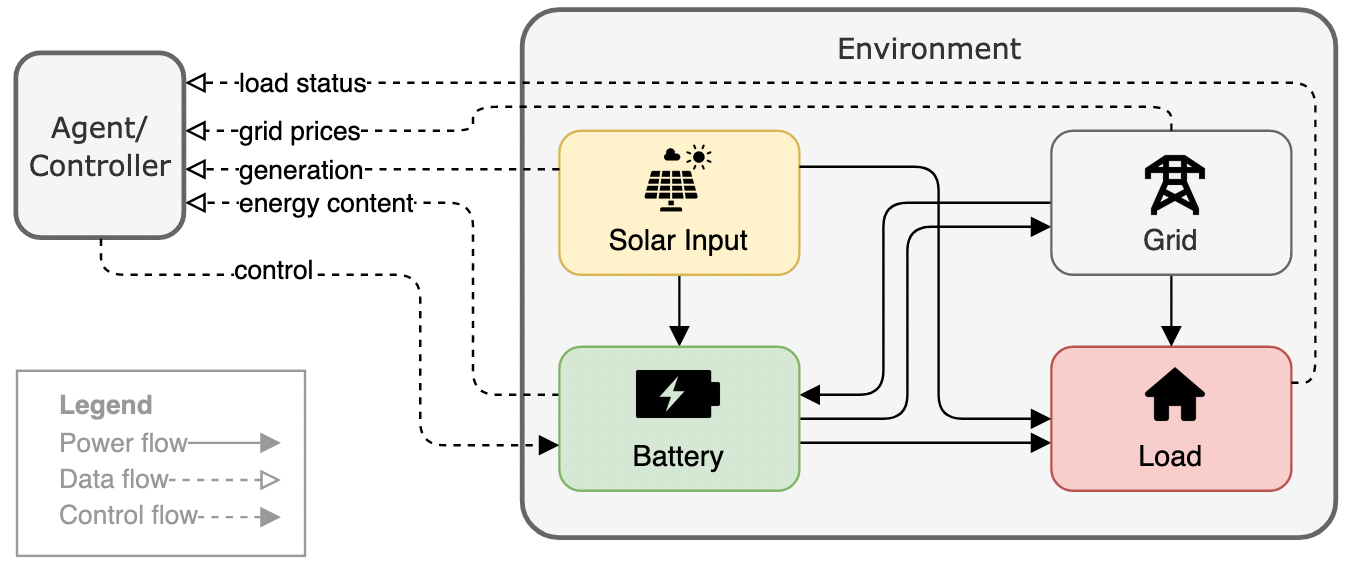

The goal is to minimise the cost incurred from using energy from the grid for home use. This goal is achieved by optimising the charging/discharging control of the battery. The Solar Agent project aims to create RL agents that are able to solve this control problem.

## 2. RL Problem Definition

In order to apply reinforcement learning (RL), we rephrase the problem as an agent interacting with an environment, as below.

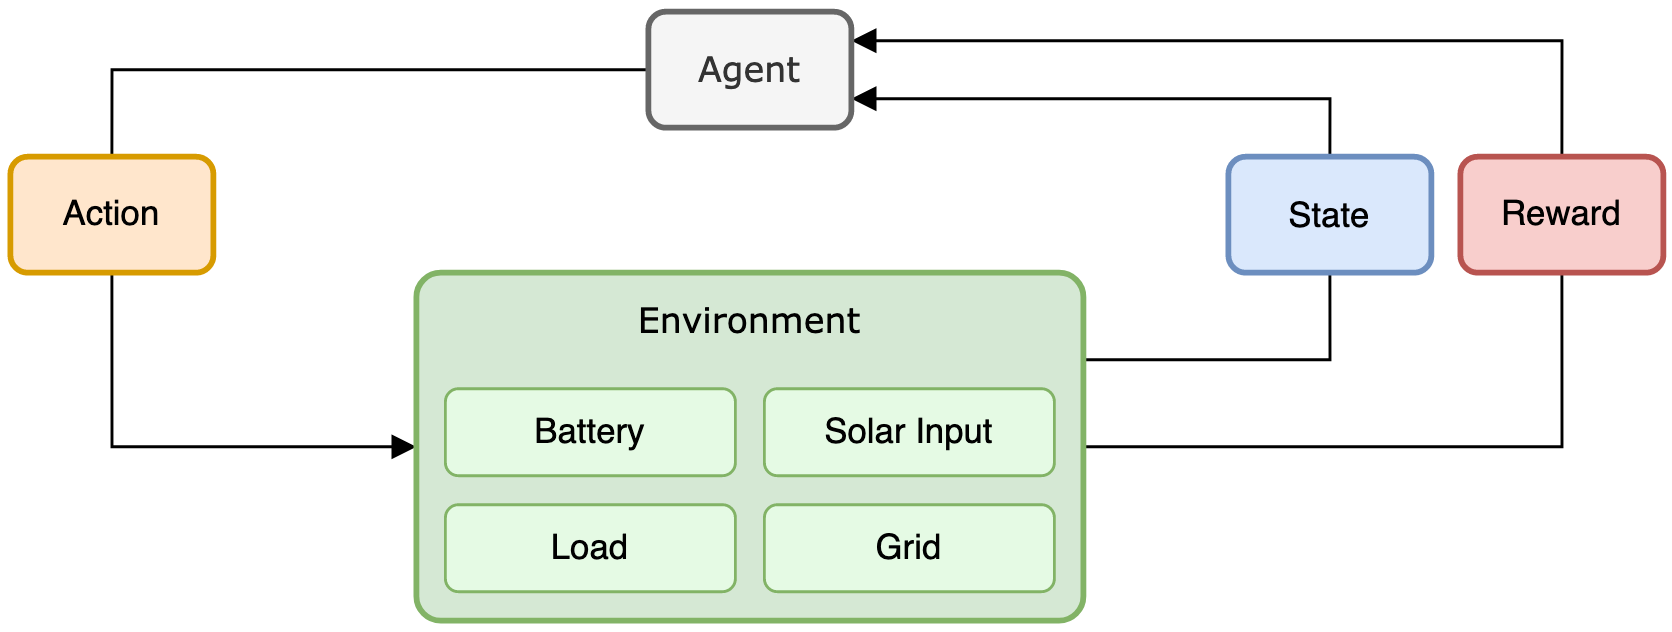

In using the Solar Agent package, we can create such an environment using the function below. This creates an environment representing the simplest case of the battery control problem: solar generation and load are non-stochastic and always follow the same pattern, the grid uses peak-demand pricing (one price below and other above certain power draw threshold) and does not accept feed-in power, and the battery can only be charged from the solar input. 

In [1]:
# Jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [2]:
import solara.envs.components.solar
import solara.envs.components.load
import solara.envs.components.grid
import solara.envs.components.battery
import solara.envs.battery_control
import solara.utils.logging
from solara.constants import PROJECT_PATH

def battery_env_creator(env_config=None):
    """Create a battery control environment."""
    
    PV_DATA_PATH = PROJECT_PATH + "/data/solar_trace_data/PV_5796.txt"
    LOAD_DATA_PATH = PROJECT_PATH + "/data/solar_trace_data/load_5796.txt"

    # Setting up components of environment
    battery_model = solara.envs.components.battery.LithiumIonBattery(size=10, 
                                                                     chemistry="NMC", 
                                                                     time_step_len=1)
    pv_model = solara.envs.components.solar.DataPV(data_path=PV_DATA_PATH,
                                                   fixed_sample_num=12)
    load_model = solara.envs.components.load.DataLoad(data_path=LOAD_DATA_PATH,
                                                      fixed_sample_num=12)
    grid_model = solara.envs.components.grid.PeakGrid(peak_threshold=1.0)

    # Fixing load and PV trace to single sample
    episode_num = 12
    load_model.fix_start(episode_num)
    pv_model.fix_start(episode_num)

    env = solara.envs.battery_control.BatteryControlEnv(
        battery = battery_model,
        pv_system = pv_model,
        grid = grid_model,
        load = load_model,
        logging_level = "WARNING",
    )
    
    return env

## 3. Training an Agent
In this section we train an agent using `RLlib`. 


### 3.1 Setup & Defining Agent
We first setup an agent based proximal policy optimisation (PPO):

In [3]:
import ray
import ray.rllib

## Initialising ray (starts background process for distributed computing)
ray.shutdown()
ray.init(logging_level="WARNING")

# Adding our environment just create to ray
ray.tune.registry.register_env("battery_control", battery_env_creator)

# Setting some logging/checkpoint saving paths
SAVE_PATH = "./tmp/ppo/battery-control-demo"
CHECK_SAVE_PATH = SAVE_PATH + "/training_checkpoints"
OUT_SAVE_PATH = SAVE_PATH + "/outputs"

agent = ray.rllib.agents.ppo.PPOTrainer(env="battery_control", config={
    "framework": "torch",
    "env_config": {},
    "output": OUT_SAVE_PATH,
    "output_compress_columns": [],
    "gamma": 0.9999999, # we set the discount factor very high
    "log_level": "WARNING",
    "lr": 5e-5,
    # Learning rate schedule.
    "lr_schedule": [
            [0, 0.0005],
            [200000, 0.000000000001],
        ]
})

2021-05-20 18:31:17,986	WARNING util.py:53 -- Install gputil for GPU system monitoring.


### 3.2 Training
We then train the agent for `NUM_ITERATIONS` iterations.

In [4]:
NUM_ITERATIONS = 10
iteration_string = ("Training iteration: {}, "
                    "Min reward: {:.3f}, Mean reward: {:.3f}, "
                    "Max reward: {:.3f}.")

for i in range(NUM_ITERATIONS):
    iteration_out = agent.train()
    print(iteration_string.format(i,
                                  iteration_out['episode_reward_min'], 
                                  iteration_out['episode_reward_mean'],
                                  iteration_out['episode_reward_max']))
    file_name = agent.save(CHECK_SAVE_PATH)
    
print("Training completed")

2021-05-20 18:31:20,461	WARNING deprecation.py:34 -- DeprecationWarning: `SampleBatch.data[..]` has been deprecated. Use `SampleBatch[..]` instead. This will raise an error in the future!


Training iteration: 0, Min reward: -1.356, Mean reward: -1.216, Max reward: -0.930.
Training iteration: 1, Min reward: -1.378, Mean reward: -1.211, Max reward: -0.946.
Training iteration: 2, Min reward: -1.320, Mean reward: -1.186, Max reward: -0.959.
Training iteration: 3, Min reward: -1.351, Mean reward: -1.163, Max reward: -0.931.
Training iteration: 4, Min reward: -1.355, Mean reward: -1.105, Max reward: -0.888.
Training iteration: 5, Min reward: -1.286, Mean reward: -1.065, Max reward: -0.871.
Training iteration: 6, Min reward: -1.262, Mean reward: -1.011, Max reward: -0.868.
Training iteration: 7, Min reward: -1.218, Mean reward: -0.997, Max reward: -0.875.
Training iteration: 8, Min reward: -1.169, Mean reward: -0.964, Max reward: -0.855.
Training iteration: 9, Min reward: -1.230, Mean reward: -0.955, Max reward: -0.854.
Training completed


## 4. Visualising Agent during Training

Using the `InteractiveEpisodes` widget we can visualise how the agent evolves during training. In the widget below, we can see how the agent acts (without exploration) after each of the training iterations above. In case something does not converge as expected, this can help us identify the issue.

In [5]:
import solara.utils.rllib
import solara.plot.widgets

episodes_data = solara.utils.rllib.run_episodes_from_checkpoints(agent=agent, check_save_path=CHECK_SAVE_PATH)
solara.plot.widgets.InteractiveEpisodes(episodes_data)

InteractiveEpisodes(children=(HBox(children=(Play(value=1, interval=400, max=30, min=1), IntSlider(value=1, ma…

## Appendix

### A. Problem Variants

Unsurprisingly, the four components of the environment come in all shapes and sizes. The goal of Solar Agent is to make a solution for one specific problem easily transferable to another. However, inevitably Solar Agent will fail to cover all types, but should enable relatively easy implementation of new variants. Below are a number of variants for each component.

#### Solar installation
- Capacity
- Weather, ...

#### Battery
- Capacity
- Chemistry (affects charging properties)
- Modelling choices

#### Load
- Type: data-based/model-based
- Data source
- Reactive (if it responds to actions by the agent)

#### Grid connection
- Pricing scheme
- Ability to sell
- Ability to charge battery